In [1]:
from mpi4py import MPI
import gmsh
import numpy as np
from scipy.spatial import cKDTree
import pyvista as pv
from dolfinx import plot

Lx, Ly = 1.0, 1.0

In [2]:
from dolfinx import mesh, fem
import ufl
import numpy as np
from dolfinx.io import gmsh as gmshio
from mpi4py import MPI

# ---------------------------------------------------------------------
# 1. Mesh and tags (same mesh as reference)
# ---------------------------------------------------------------------
ref = 4
filename = f"regular_mesh_{ref}.msh"
msh, cell_markers, facet_markers = gmshio.read_from_msh(filename, MPI.COMM_WORLD, 0, gdim=2)[0:3]

tdim = msh.topology.dim  # 2
fdim = tdim - 1          # 1

lc = 1.0 / (2**ref)      # mesh size
h = lc

omega = msh

# ---------------------------------------------------------------------
# 2. Function space (standard CG on the bulk only)
# ---------------------------------------------------------------------
order = 1
V = fem.functionspace(omega, ("Lagrange", order))

# ---------------------------------------------------------------------
# 3. Trial / Test / Solution function
# ---------------------------------------------------------------------
phi = ufl.TestFunction(V)
p = fem.Function(V, name="p")
dp = ufl.TrialFunction(V)

# ---------------------------------------------------------------------
# 4. Coordinates and data
# ---------------------------------------------------------------------
x = ufl.SpatialCoordinate(omega)
# f_m = fem.Constant(omega, 0.0)
# f_m = 2*(x[1] - x[1]**2 + x[0] - x[0]**2)
f_m = x[1]
def f_callable(x):
    return x[1]

f = fem.Function(V)
f.interpolate(f_callable)
# create function
k_m = fem.Function(V, name="kappa")

def k_callable(x):
    # x is array with shape (gdim, N). compute scalar per point, return shape (1,N)
    vals = 2*(x[0])
    return vals[np.newaxis, :]

k_m.interpolate(k_callable)

kappa = 1.0
# k_m = fem.Constant(omega, kappa)  # bulk permeability

dx = ufl.Measure("dx", domain=omega)

# compute domain bbox to locate sides
coords = omega.geometry.x
xx = coords[:, 0]
yy = coords[:, 1]
xmin, xmax = xx.min(), xx.max()
ymin, ymax = yy.min(), yy.max()

tol = 1e-10 * max(xmax - xmin, ymax - ymin)

# locate boundary facets for bottom (y = ymin) and top (y = ymax)
bottom_facets = mesh.locate_entities_boundary(
    omega, fdim, lambda x: np.isclose(x[1], ymin, atol=tol)
)
top_facets = mesh.locate_entities_boundary(
    omega, fdim, lambda x: np.isclose(x[1], ymax, atol=tol)
)

# create meshtags for those Neumann parts (optional — kept for clarity)
indices = np.concatenate([bottom_facets, top_facets]).astype(np.int32)
values = np.concatenate([
    np.full(bottom_facets.shape, 10, dtype=np.int32),  # bottom tag = 10
    np.full(top_facets.shape,    20, dtype=np.int32),  # top tag    = 20
])
neumann_tags = mesh.meshtags(omega, fdim, indices, values)

# boundary measure (we'll use ds over the whole boundary with conditional g_N)
dsN = ufl.Measure("ds", domain=omega)  # we integrate g_N over the boundary

# Neumann data as conditional on the y coordinate (same as reference)
# g_N = ufl.conditional(
#     ufl.lt(abs(x[1] - ymax), tol),
#     -1.0,                                # top
#     ufl.conditional(
#         ufl.lt(abs(x[1] - ymin), tol),
#         2.0,                             # bottom
#         0.0                              # elsewhere
#     ),
# )

# ---------------------------------------------------------------------
# 5. Weak form (standard Darcy / Poisson form)
# ---------------------------------------------------------------------
a = ufl.inner(k_m * ufl.grad(dp), ufl.grad(phi)) * dx
L = f_m * phi * dx
# L -= g_N * phi * dsN

# Form for assembling (bilinear/trilinear functions expect TrialFunction in a)
A_form = ufl.inner(k_m * ufl.grad(dp), ufl.grad(phi)) * dx
b_form = L

# ---------------------------------------------------------------------
# 6. Dirichlet BCs (left/right like reference)
# ---------------------------------------------------------------------
# locate dofs on each side
left_dofs   = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[0], xmin, atol=tol))
right_dofs  = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[0], xmax, atol=tol))
top_dofs  = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[1], ymax, atol=tol))
bottom_dofs  = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[1], ymin, atol=tol))

all_dofs = np.unique(np.concatenate([left_dofs, right_dofs]))
dof_coords = V.tabulate_dof_coordinates()

p_bc_fun = fem.Function(V)
p_bc_fun.x.array[left_dofs] = 0.0
p_bc_fun.x.array[right_dofs] = dof_coords[right_dofs, 1] / 2.0
# p_bc_fun.x.array[top_dofs] = 0.0
# p_bc_fun.x.array[bottom_dofs] = 0.0

bc = fem.dirichletbc(p_bc_fun, all_dofs)
bcs = [bc]

# ---------------------------------------------------------------------
# 7. Solve linear problem using dolfinx.fem.petsc.LinearProblem
# ---------------------------------------------------------------------
from dolfinx.fem import petsc

linear_problem = petsc.LinearProblem(
    a=A_form,
    L=b_form,
    bcs=bcs,
    petsc_options={
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
        "ksp_error_if_not_converged": True,
    },
    petsc_options_prefix="pmix_"
)

p_sol = linear_problem.solve()
p_sol.name = "pressure"

# optionally copy into p Function if you prefer
p.x.array[:] = p_sol.x.array[:]

# ---------------------------------------------------------------------
# 8. Diagnostics
# ---------------------------------------------------------------------
print("DOFs in V:", V.dofmap.index_map.size_global)


Info    : Reading 'regular_mesh_4.msh'...
Info    : 2337 entities
Info    : 289 nodes
Info    : 2337 elements
Info    : Done reading 'regular_mesh_4.msh'
DOFs in V: 289


In [3]:
# Access mesh geometry
tdim = omega.topology.dim

# Gather coordinates and connectivity
omega_geometry = omega.geometry.x[:,0:2]  # global array of vertex coords
# Build cell->vertex mapping (fast access)
# Using dolfinx.Cell to get connectivity is more robust, but below uses mesh.topology
cells = omega.topology.connectivity(0, tdim)  # vertices -> cells
# Instead get cell->vertex mapping via mesh.topology.index_map?
# Simpler: use mesh.geometry.x with mesh.topology.connectivity(tdim, 0)
ctv = omega.topology.connectivity(tdim, 0)
if ctv is None:
    omega.topology.create_connectivity(tdim, 0)
    ctv = omega.topology.connectivity(tdim, 0)
# ctv.array() gives flattened vertex indices -> need per-cell view
# There's a helper to get cell entity indices
num_cells = omega.topology.index_map(tdim).size_local  # per-rank local count
# We'll iterate over local cells only
local_cells = np.arange(num_cells, dtype=np.int32)

# For evaluating u_h and kappa, we can use u_h.x.array if needed.
# But easier: create a point evaluation lambda to get value at a point
from dolfinx.fem import Function
u_func = p_sol
local_fluxes = {}
V_dofmap = V.dofmap.index_map.local_range  # not directly used; we'll query dofs per cell

# Get dof indices per cell
# Using dolfinx.fem.locate_dofs_topological is one option, but below we get cell_dofs
dofmap = V.dofmap
# But to avoid uncertain reshape semantics, use mesh.topology.connectivity(tdim, 0).entities
# Simpler robust approach: use dolfinx.mesh.cells() to get local cells vertex indices
try:
    from dolfinx.mesh import cells as dolfinx_cells
    local_cell_vertices = dolfinx_cells(mesh)
except Exception:
    # fallback: create by slicing connectivity
    # arr = ctv.array
    # local_cell_vertices = arr.reshape((-1, 3))
    local_cell_vertices = np.array([ctv.links(c) for c in range(ctv.num_nodes)])

In [4]:
tdim = omega.topology.dim
omega.topology.create_connectivity(tdim, tdim - 1)
omega.topology.create_connectivity(tdim - 1, tdim)

c2f = omega.topology.connectivity(tdim, tdim - 1)
f2c = omega.topology.connectivity(tdim - 1, tdim)

num_cells = omega.topology.index_map(tdim).size_local

local_cell_adjacent = [[] for _ in range(num_cells)]

for c in range(num_cells):
    neighbors = set()
    for ff in c2f.links(c):
        for cc in f2c.links(ff):
            if cc != c:
                neighbors.add(int(cc))
    local_cell_adjacent[c] = list(neighbors)


In [5]:
#facet vertices
tdim = omega.topology.dim
fdim = tdim - 1

# Make sure facet -> vertex connectivity exists
if omega.topology.connectivity(fdim, 0) is None:
    omega.topology.create_connectivity(fdim, 0)

f2v = omega.topology.connectivity(fdim, 0)

num_facets = omega.topology.index_map(fdim).size_local
local_facets = np.arange(num_facets, dtype=np.int32)

facet_vertices = []
facet_coords = []

x = omega.geometry.x  # global vertex coordinates

for ff in local_facets:
    verts = f2v.links(ff)          # vertex indices of facet f
    coords = x[verts]             # coordinates of those vertices

    facet_vertices.append(verts)
    facet_coords.append(coords)


In [6]:
import numpy as np
import torch
import torch.nn as nn
import cma
from tqdm import tqdm
import basix
from dolfinx import default_scalar_type, mesh as dmesh
import math

# ---------------------------------------------------------
# 1. Define a small NN for flux (or flux correction)
# ---------------------------------------------------------
class AdaptiveTanh(nn.Module):
    def __init__(self, n=5.0):
        super().__init__()
        self.a = nn.Parameter(torch.tensor(1.0 / n))  # scalar a^k

    def forward(self, x):
        return torch.tanh(self.a * x)
    
class FluxNet(nn.Module):
    def __init__(self, in_dim=1, out_dim=1, hidden_dim=32, n = 5.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            AdaptiveTanh(n=n),
            # nn.Linear(hidden_dim, hidden_dim),
            # AdaptiveTanh(n=n),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, x):
        # x: tensor of shape (N, in_dim)
        return self.net(x)
    
    def slope_recovery_term(self):
        # collect all a^k from hidden layers
        slopes = []
        for m in self.net:
            if isinstance(m, AdaptiveTanh):
                slopes.append(m.a)

        a = torch.stack(slopes)                 # shape: (L-1,)
        return 1.0 / torch.mean(torch.exp(a))   # S(a)


num_subdomains = len(local_cell_vertices)

nets = [FluxNet(in_dim=2, out_dim=2, hidden_dim=8) for _ in range(num_subdomains)]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for net in nets:
    net.to(device)

# ---------------------------------------------------------
# 2. Utilities to flatten / unflatten parameters
# ---------------------------------------------------------

def get_flat_params_from(net: nn.Module) -> np.ndarray:
    """
    Returns a 1D numpy array containing all parameters of the network.
    """
    with torch.no_grad():
        vec = torch.nn.utils.parameters_to_vector(net.parameters())
    return vec.cpu().numpy()


def set_flat_params_to(net: nn.Module, theta: np.ndarray):
    """
    Loads a 1D numpy array `theta` back into the network parameters.
    """
    theta_torch = torch.tensor(theta, dtype=torch.float32)
    with torch.no_grad():
        torch.nn.utils.vector_to_parameters(theta_torch, net.parameters())


# ---------------------------------------------------------
# 3. Define a loss function for CMA-ES (gradient-free)
# ---------------------------------------------------------

# Precompute sample points (these play the role of quadrature points)
# x_np = np.linspace(0.0, 1.0, 128, endpoint=True)
x_np = V.tabulate_dof_coordinates()
x_torch = torch.tensor(x_np, dtype=torch.float32).view(-1, 1)
gdim = omega_geometry.shape[1]

xi = torch.tensor(
        [
            0.5 * (1.0 - 1.0 / math.sqrt(3.0)),
            0.5 * (1.0 + 1.0 / math.sqrt(3.0)),
        ],
        dtype=torch.float32,
        device=device,
    )
wi = torch.tensor([0.5, 0.5], dtype=torch.float32, device=device)

def compute_flux_loss(nets, it=None):
    device = next(nets[0].parameters()).device

    loss_sd = [torch.zeros((), device=device) for _ in range(num_subdomains)]
    count_sd = [0 for _ in range(num_subdomains)]

    for local_cell_idx, cell_verts in enumerate(local_cell_vertices):
        sd = cell_to_subdomain(local_cell_idx)
        net = nets[sd]
        count_sd[sd] += 1

        coords = omega_geometry[cell_verts]
        centroid = np.mean(coords, axis=0).reshape(1, -1)

        loc_cells = np.array([[0, 1, 2]], dtype=np.int64)

        coord_el = basix.ufl.element(
            "Lagrange", "triangle", 1, shape=(gdim,)
        )

        local_mesh = dmesh.create_mesh(
            MPI.COMM_SELF, loc_cells, coord_el, coords
        )

        V_loc = fem.functionspace(local_mesh, ("CG", order + 1, (gdim,)))
        P_loc = fem.functionspace(local_mesh, ("CG", order))

        p_K = fem.Function(P_loc)
        k_m_loc = fem.Function(P_loc)
        f_m_loc = fem.Function(P_loc)

        x_loc = V_loc.tabulate_dof_coordinates()[:, :2]
        x_loc_torch = torch.tensor(x_loc, dtype=torch.float32, device=device)

        # ---------------- r_theta integral ----------------
        coords_t = torch.tensor(coords, dtype=torch.float32, device=device)

        edge_indices = [(0, 1), (1, 2), (2, 0)]
        int_r_local = torch.zeros((), device=device)

        num_sub = 3 #sub integral section

        for (i0, i1) in edge_indices:
            x0 = coords_t[i0]
            x1 = coords_t[i1]
            t = x1 - x0
            L = torch.linalg.norm(t)
            if L <= 0:
                continue

            n_edge = (torch.stack([t[1], -t[0]]) / L)
            n_edge = torch.tensor(n_edge, dtype=torch.float32)
            centroid_t = torch.tensor(centroid, dtype=torch.float32, device=device).squeeze()
            midpoint = 0.5 * (x0 + x1)
            if torch.dot(n_edge, centroid_t - midpoint) > 0:
                n_edge = -n_edge

            h = 1.0 / num_sub

            for j in range(num_sub):
                s_left = j * h
                for k in range(len(xi)):
                    s = s_left + h * xi[k]
                    w = h * wi[k]

                    x_q = x0 + s * t
                    r_q = net(x_q.unsqueeze(0))[0]

                    int_r_local += torch.dot(r_q, n_edge) * L * w

        # ---------------- CG flux + source ----------------
        global_dofs = V.dofmap.cell_dofs(local_cell_idx)
        local_dofs = P_loc.dofmap.cell_dofs(0)

        p_K.x.array[local_dofs] = p_sol.x.array[global_dofs]
        k_m_loc.x.array[local_dofs] = k_m.x.array[global_dofs]
        f_m_loc.x.array[local_dofs] = f.x.array[global_dofs]

        p_K.x.scatter_forward()
        k_m_loc.x.scatter_forward()
        f_m_loc.x.scatter_forward()

        q_CG = -k_m_loc * ufl.grad(p_K)
        n_K = ufl.FacetNormal(local_mesh)

        int_qcg = fem.assemble_scalar(
            fem.form(ufl.dot(q_CG, n_K) * ufl.ds(domain=local_mesh))
        )
        int_f = fem.assemble_scalar(
            fem.form(f_m_loc * ufl.dx(domain=local_mesh))
        )

        residual = (
            int_r_local
            + torch.tensor(float(int_qcg), device=device)
            - torch.tensor(float(int_f), device=device)
        )

        loss_sd[sd] += residual**2

    for k in range(num_subdomains):
        if count_sd[k] > 0:
            loss_sd[k] /= count_sd[k]

    return loss_sd

def integrate_edge_flux(net, x0, x1, n_edge, L, xi, wi, num_sub):
    """
    Compute ∫_edge (net(x)·n_edge) ds via composite quadrature.
    """
    t = x1 - x0
    h = 1.0 / num_sub

    int_edge = 0.0
    for j in range(num_sub):
        s_left = j * h
        for k in range(len(xi)):
            s = s_left + h * xi[k]
            w = h * wi[k]

            x_q = x0 + s * t
            r_q = net(x_q.unsqueeze(0))[0]  # (dim,)

            int_edge = int_edge + torch.dot(r_q, n_edge) * L * w

    return int_edge

# contiunity loss
import random
def compute_subdomain_continuity(nets):
    device = next(nets[0].parameters()).device
    num_vertices = omega_geometry.shape[0]
    
    # 1) Build vertex → {subdomains} map
    vertex_subdomains = [set() for _ in range(num_vertices)]

    for local_cell_idx, cell_verts in enumerate(local_cell_vertices):
        sd = cell_to_subdomain(local_cell_idx)  # 0,1,2,3
        for v in cell_verts:
            vertex_subdomains[v].add(sd)

    # Sort so we can index [0], [1] deterministically
    vertex_subdomains = [sorted(vv) for vv in vertex_subdomains]

    # 2) Loop over cells and edges, accumulate per-subdomain penalty
    loss_sd = [torch.zeros((), device=device) for _ in range(num_subdomains)]
    count_sd = [0 for _ in range(num_subdomains)]

    tdim = omega.topology.dim
    cells_vtx = omega.topology.connectivity(0, tdim)

    

    pairs = list(enumerate(local_cell_vertices))
    random.shuffle(pairs)

    # for local_cell_idx, cell_verts in enumerate(local_cell_vertices):
    for local_cell_idx, cell_verts in pairs:
        sd = cell_to_subdomain(local_cell_idx)
        coords = omega_geometry[cell_verts]
        centroid = np.mean(coords, axis=0).reshape(1, -1)
        centroid_t = torch.tensor(centroid, dtype=torch.float32, device=device).squeeze()
        loc_cells = np.array([[0, 1, 2]], dtype=np.int64)

        # edges in terms of *global vertex indices*
        # edge_indices = [
        #     (cell_verts[0], cell_verts[1]),
        #     (cell_verts[1], cell_verts[2]),
        #     (cell_verts[2], cell_verts[0])
        # ]
        edge_indices_loc = [(0, 1), (1, 2), (2, 0)]

        coord_el = basix.ufl.element(
            "Lagrange", "triangle", 1, shape=(gdim,)
        )

        local_mesh = dmesh.create_mesh(
            MPI.COMM_SELF, loc_cells, coord_el, coords
        )
        tdim = local_mesh.topology.dim
        fdim = tdim - 1
        # Make sure facet entities / connectivity exist
        local_mesh.topology.create_connectivity(tdim, fdim)
        local_mesh.topology.create_connectivity(fdim, tdim)

        # Total number of facets
        num_facets = local_mesh.topology.index_map(fdim).size_local

        V_loc = fem.functionspace(local_mesh, ("CG", order + 1, (gdim,)))
        P_loc = fem.functionspace(local_mesh, ("CG", order))

        p_K = fem.Function(P_loc)
        k_m_loc = fem.Function(P_loc)
        f_m_loc = fem.Function(P_loc)

        x_loc = V_loc.tabulate_dof_coordinates()[:, :2]
        x_loc_torch = torch.tensor(x_loc, dtype=torch.float32, device=device)

        # ---------------- r_theta integral ----------------
        coords_t = torch.tensor(coords, dtype=torch.float32, device=device)

        # ---------------- CG flux + source ----------------
        global_dofs = V.dofmap.cell_dofs(local_cell_idx)
        local_dofs = P_loc.dofmap.cell_dofs(0)

        p_K.x.array[local_dofs] = p_sol.x.array[global_dofs]
        k_m_loc.x.array[local_dofs] = k_m.x.array[global_dofs]
        f_m_loc.x.array[local_dofs] = f.x.array[global_dofs]

        p_K.x.scatter_forward()
        k_m_loc.x.scatter_forward()
        f_m_loc.x.scatter_forward()

        q_CG = -k_m_loc * ufl.grad(p_K)
        n_K = ufl.FacetNormal(local_mesh)

        cell_adj = local_cell_adjacent[local_cell_idx]

        for (v0, v1) in edge_indices_loc:
            i0 = cell_verts[v0]
            i1 = cell_verts[v1]
            # Only interface edges between exactly 2 subdomains, and the same pair at both endpoints
            if (len(vertex_subdomains[i0]) >= 2 and len(vertex_subdomains[i1]) >= 2):
                edge_sds = set(vertex_subdomains[i0]) & set(vertex_subdomains[i1])

                # Remove the current cell's subdomain
                sd_adj_set = edge_sds - {sd}

                if len(sd_adj_set) != 1:
                    # edge not between exactly two subdomains, skip or handle
                    continue
                sd_adj = next(iter(sd_adj_set))
                
                #find the CG flux in the edge
                local_mesh.topology.create_connectivity(0, fdim)
                local_mesh.topology.create_connectivity(fdim, 0)

                v_to_f = local_mesh.topology.connectivity(0, fdim)
                f_to_v = local_mesh.topology.connectivity(fdim, 0)

                edge_id = None
                for ff in v_to_f.links(v0):
                    verts = f_to_v.links(ff)
                    if v1 in verts:
                        edge_id = ff
                        break

                # All facet indices
                facets = np.arange(num_facets, dtype=np.int32)

                # Tag values: 0 = unmarked
                values = np.zeros(num_facets, dtype=np.int32)

                # Pick ANY positive integer as the tag
                EDGE_TAG = 1
                values[edge_id] = EDGE_TAG

                facet_tags = mesh.meshtags(local_mesh, fdim, facets, values)

                ds = ufl.Measure("ds", domain=local_mesh, subdomain_data=facet_tags)

                int_qcg_edge = fem.assemble_scalar(
                    fem.form(ufl.dot(q_CG, n_K) * ds(EDGE_TAG))
                )

                # LOCAL MESH ADJ
                # find neighbor cell along this edge (same as code 2)
                cells0 = cells_vtx.links(i0)
                cells1 = cells_vtx.links(i1)
                common_cells = np.intersect1d(cells0, cells1)
                neighbor_cells = [int(c) for c in common_cells if int(c) != local_cell_idx]
                if len(neighbor_cells) == 0:
                    continue  # boundary / inconsistent mesh
                local_cell_idx_adj = neighbor_cells[0]

                cell_verts_adj = local_cell_vertices[local_cell_idx_adj]
                # find local indices in the neighbor that match i0, i1
                try:
                    loc0_adj = int(np.where(cell_verts_adj == i0)[0][0])
                    loc1_adj = int(np.where(cell_verts_adj == i1)[0][0])
                except IndexError:
                    # neighbor doesn't actually share both these vertices -> skip
                    continue
                coords_adj = omega_geometry[cell_verts_adj]
                centroid_adj = np.mean(coords_adj, axis=0).reshape(1, -1)
                centroid_t_adj = torch.tensor(centroid_adj, dtype=torch.float32, device=device).squeeze()
                local_mesh_adj = dmesh.create_mesh(
                    MPI.COMM_SELF, loc_cells, coord_el, coords_adj
                )
                V_loc_adj = fem.functionspace(local_mesh_adj, ("CG", order + 1, (gdim,)))
                P_loc_adj = fem.functionspace(local_mesh_adj, ("CG", order))

                p_K_adj = fem.Function(P_loc_adj)
                k_m_loc_adj = fem.Function(P_loc_adj)

                x_loc_adj = V_loc_adj.tabulate_dof_coordinates()[:, :2]

                global_dofs_adj = V.dofmap.cell_dofs(local_cell_idx_adj)
                local_dofs_adj = P_loc_adj.dofmap.cell_dofs(0)

                p_K_adj.x.array[local_dofs_adj] = p_sol.x.array[global_dofs_adj]
                k_m_loc_adj.x.array[local_dofs_adj] = k_m.x.array[global_dofs_adj]

                p_K_adj.x.scatter_forward()
                k_m_loc_adj.x.scatter_forward()

                q_CG_adj = -k_m_loc_adj * ufl.grad(p_K_adj)
                n_K_adj = ufl.FacetNormal(local_mesh_adj)

                #find the CG flux adj in the edge
                local_mesh_adj.topology.create_connectivity(0, fdim)
                local_mesh_adj.topology.create_connectivity(fdim, 0)

                v_to_f_adj = local_mesh_adj.topology.connectivity(0, fdim)
                f_to_v_adj = local_mesh_adj.topology.connectivity(fdim, 0)

                edge_id_adj = None
                for ff in v_to_f_adj.links(loc0_adj):
                    verts = f_to_v_adj.links(ff)
                    if loc1_adj in verts:
                        edge_id_adj = ff
                        break

                # All facet indices
                facets_adj = np.arange(num_facets, dtype=np.int32)

                # Tag values: 0 = unmarked
                values_adj = np.zeros(num_facets, dtype=np.int32)

                # Pick ANY positive integer as the tag
                EDGE_TAG = 1
                values_adj[edge_id_adj] = EDGE_TAG

                facet_tags_adj = mesh.meshtags(local_mesh_adj, fdim, facets_adj, values_adj)

                ds_adj = ufl.Measure("ds", domain=local_mesh_adj, subdomain_data=facet_tags_adj)

                int_qcg_edge_adj = fem.assemble_scalar(
                    fem.form(ufl.dot(q_CG_adj, n_K_adj) * ds_adj(EDGE_TAG))
                )

                # ---- geometric data (on the right device) ----
                x0 = torch.tensor(omega_geometry[i0], dtype=torch.float32, device=device)
                x1 = torch.tensor(omega_geometry[i1], dtype=torch.float32, device=device)

                t = x1 - x0
                L = torch.linalg.norm(t)
                if L <= 0:
                    continue

                n_edge = torch.stack([t[1], -t[0]]) / L
                midpoint = 0.5 * (x0 + x1)
                if torch.dot(n_edge, centroid_t - midpoint) > 0:
                    n_edge = -n_edge

                # subdomain pair sharing this edge
                # if vertex_subdomains[i0][0] == sd:
                #     sd_adj = vertex_subdomains[i0][1]
                # elif vertex_subdomains[i0][1] == sd:
                #     sd_adj = vertex_subdomains[i0][0]
                net_sd = nets[sd]
                net_sd_adj  = nets[sd_adj]

                int_net_edge = integrate_edge_flux(net_sd, x0, x1, n_edge, L, xi, wi, num_sub=3)
                int_net_edge_adj = integrate_edge_flux(net_sd_adj, x0, x1, -n_edge, L, xi, wi, num_sub=3)

                # add the same penalty to both subdomains
                res = int_net_edge + int_qcg_edge + int_net_edge_adj + int_qcg_edge_adj
                loss_sd[sd] += res**2
                # loss_sd[sd_adj]  += res_con
                count_sd[sd] += 1
                # count_sd[sd_adj]  += 1

    # 3) normalize by number of contributions per subdomain
    for k in range(num_subdomains):
        if count_sd[k] > 0:
            loss_sd[k] /= count_sd[k]

    return loss_sd
        
def grad_norm(model):
    total_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.detach().norm(2)
            total_norm += param_norm**2
    return total_norm.sqrt()

num_cells = len(local_cell_vertices)
cells_per_sd = num_cells // num_subdomains

def cell_to_subdomain(cell_idx):
    return min(cell_idx // cells_per_sd, num_subdomains - 1)

def l2_norm_network(net, omega_geometry, dx=None, weights=None, device=None):
    """
    Approximate L2 norm of `net` over the set of points omega_geometry.

    Parameters
    ----------
    net : nn.Module
        Network with output shape (N, out_dim).
    omega_geometry : array-like, shape (N, in_dim)
        Coordinates where the network is evaluated.
    dx : float, optional
        Uniform measure per point, e.g. cell size. If given and `weights` is None:
            integral ≈ dx * sum_i ||u(x_i)||^2
    weights : array-like, optional
        Non-uniform weights w_i (e.g. quadrature weights * cell volumes).
        If given:
            integral ≈ sum_i w_i ||u(x_i)||^2
    device : torch.device, optional
        Device where computation runs. If None, inferred from `net`.

    Returns
    -------
    torch.Tensor
        Scalar tensor: approximate L2 norm.
    """
    if device is None:
        device = next(net.parameters()).device

    x = torch.as_tensor(omega_geometry, dtype=torch.float32, device=device)
    u = net(x)                           # (N, out_dim)
    norms_sq = torch.sum(u**2, dim=1)    # ||u(x_i)||^2, shape (N,)

    if weights is not None:
        w = torch.as_tensor(weights, dtype=torch.float32, device=device)
        assert w.shape == norms_sq.shape, "weights must have same shape as points"
        integral_approx = torch.sum(w * norms_sq)
    elif dx is not None:
        integral_approx = dx * torch.sum(norms_sq)
    else:
        # No geometric info: treat as average over points.
        # If |Ω| = 1 (e.g. domain [0,1]^d), this coincides with L2 norm.
        integral_approx = torch.mean(norms_sq)

    return integral_approx

def grad_norm_from_loss(loss, net):
    """
    Compute L2 norm of gradients of `loss` w.r.t. all parameters of `net`.
    Uses autograd.grad (does NOT write into param.grad).
    """
    grads = torch.autograd.grad(
        loss,
        [p for p in net.parameters() if p.requires_grad],
        retain_graph=True,
        create_graph=False,
        allow_unused=True,
    )
    sq_sum = 0.0
    for g in grads:
        if g is not None:
            sq_sum = sq_sum + g.pow(2).sum()
    return sq_sum.sqrt()

# ---------------------------------------------------------
# 4. Train the network with Adam (gradient-based)
# ---------------------------------------------------------
# import torch

# Put network on desired device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# net.to(device)

# Adam optimizer
learning_rate = 1e-3
all_params = []
for net in nets:
    all_params += list(net.parameters())

optimizer = torch.optim.Adam(all_params, lr=1e-3)
# optimizers = [
#     torch.optim.Adam(nets[k].parameters(), lr=1e-3)
#     for k in range(num_subdomains)
# ]

max_epochs = 800    # or whatever you like
mse_it = []

best_loss = float("inf")
best_state = None
W_f = 1.0e3   # flux term
W_c = 1.0e2     # continuity
W_a = 1.0    # slope regularizer (between 0.007 and 0.07 is reasonable)
# W_r = 1.0e1
# ckpt = torch.load("checkpoint.pt")
# net.load_state_dict(ckpt["model_state_dict"])
# optimizer.load_state_dict(ckpt["optimizer_state_dict"])
# start_epoch = ckpt["epoch"] + 1

loss_sd_arr = [[] for _ in range(num_subdomains)]
loss_cont_arr = [[] for _ in range(num_subdomains)]
loss_total_arr = [[] for _ in range(num_subdomains)]

loss_lc_avg_arr = []
loss_cont_avg_arr = []


# for epoch in range(max_epochs):

#     # zero all grads
#     for opt in optimizers:
#         opt.zero_grad()

#     loss_sd = compute_flux_loss(nets)  # list of 4 torch scalars

#     loss_continuity_sd = compute_subdomain_continuity(nets)  # list of 4 torch scalars

#     S_a = [net_i.slope_recovery_term() for net_i in nets]

#     # net_norm = [l2_norm_network(net, omega_geometry, dx=lc) for net in nets]
 
#     loss = [W_f*loss_sd[k] + W_c*loss_continuity_sd[k] + W_a*S_a[k] for k in range(num_subdomains)]
#     # loss = [loss_sd[k] + loss_continuity_sd[k] + S_a[k] for k in range(num_subdomains)]

#     # list_grad_f = []
#     # list_grad_c = []
#     # list_grad_a = []
#     # list_grad_r = []
#     # for k in range(num_subdomains):
#     #     loss_sd[k].backward(retain_graph=True)
#     #     grad_f = grad_norm(nets[k])
#     #     list_grad_f.append(float(grad_f))
#     #     loss_continuity_sd[k].backward(retain_graph=True)
#     #     grad_c = grad_norm(nets[k])
#     #     list_grad_c.append(float(grad_c))
#     #     S_a[k].backward(retain_graph=True)
#     #     grad_a = grad_norm(nets[k])
#     #     list_grad_a.append(float(grad_a))
#     #     net_norm[k].backward(retain_graph=True)
#     #     grad_r = grad_norm(nets[k])
#     #     list_grad_r.append(float(grad_r))

#     # backward + step per subdomain
#     for k in range(num_subdomains):
#         loss[k].backward(retain_graph=True)
#         optimizers[k].step()
#         loss_sd_arr[k].append(loss_sd[k].item())
#         loss_cont_arr[k].append(loss_continuity_sd[k].item())
#         loss_total_arr[k].append(loss[k].item())

#     avg_F = sum(loss_sd) / len(loss_sd)
#     avg_C = sum(loss_continuity_sd) / len(loss_continuity_sd)
#     loss_lc_avg_arr.append(float(avg_F))
#     loss_cont_avg_arr.append(float(avg_C))

#     if epoch % 10 == 0:
#         print(
#             f"[Epoch {epoch:4d}] "
#             f"F_avg={avg_F.item():.3e} | "
#             f"C_avg={avg_C.item():.3e}"
#         )



# 🔑 restore best parameters after training
# net.load_state_dict(best_state)


# print("Training finished. Final loss:", best_loss)


In [ ]:
eps = 1e-6
W_f = 1.0e3   # flux term
W_c = 1.0e2     # continuity
W_a = 1.0
# initialize once
lambdas = [torch.zeros(1, device=device) for _ in range(num_subdomains)]
rho = 10.0   # penalty parameter (tunable)
is_update_rho = False

for epoch in range(max_epochs):

    # zero all grads
    # for opt in optimizers:
    optimizer.zero_grad()

    # forward
    loss_sd = compute_flux_loss(nets)                       # list of num_subdomains scalars
    loss_continuity_sd = compute_subdomain_continuity(nets) # list of num_subdomains scalars
    S_a = [net_i.slope_recovery_term() for net_i in nets]   # list of num_subdomains scalars

    # ----- gradient-based weight update every 10 epochs -----
    if epoch % 10 == 0:
        grad_f_list, grad_c_list, grad_a_list = [], [], []

        for k in range(num_subdomains):
            net_k = nets[k]

            g_f = grad_norm_from_loss(loss_sd[k], net_k)
            g_c = grad_norm_from_loss(loss_continuity_sd[k], net_k)
            g_a = grad_norm_from_loss(S_a[k], net_k)

            grad_f_list.append(g_f)
            grad_c_list.append(g_c)
            grad_a_list.append(g_a)

        # average gradient norms over subdomains
        g_f = torch.stack(grad_f_list).mean()
        g_c = torch.stack(grad_c_list).mean()
        g_a = torch.stack(grad_a_list).mean()

        # choose W_f as the anchor (scale is arbitrary)
        with torch.no_grad():
            # anchor on W_a
            W_a = 1.0
            W_f = (W_a * g_a / (g_f + eps)).item()
            W_c = (W_a * g_a / (g_c + eps)).item()

            # later in training, every 10 epochs after updating weights:
            # boost W_c
            # if epoch > 1:
            #     beta = 2.0  # or 1.0 for stronger boost
            #     Lc = avg_C.item()
            #     ratio = Lc / (Lc0 + 1e-12)

            #     if ratio <= 0.5:
            #         boost = 1.0
            #     else:
            #         boost = (ratio / 0.5) ** beta

            #     # optional: avoid crazy explosions
            #     boost = min(boost, 100.0)
            #     if avg_F < 1e-9:
            #         boost = 100

            #     W_c *= boost
            # for k in range(num_subdomains):
            #     lambdas[k] += rho * loss_continuity_sd[k].detach()

            # avg_lmbd = np.average(lambdas)

        # print(
        #     f"[Epoch {epoch:4d}] grad-based weights: "
        #     f"|g_f|={g_f.item():.3e}, |g_c|={g_c.item():.3e}, |g_a|={g_a.item():.3e} | "
        #     f"W_f={W_f:.3e}, W_c={W_c:.3e}, W_a={W_a:.3e}"
        # )

    # ----- combined loss with current weights -----
    loss = [
        W_f * loss_sd[k] +
        W_c * loss_continuity_sd[k]
        # + lambdas[k] * loss_continuity_sd[k]
        + W_a * S_a[k]
        for k in range(num_subdomains)
    ]
    total_loss = torch.sum(torch.stack(loss))
    total_loss.backward()
    optimizer.step()
    # backward + step per subdomain
    # for k in range(num_subdomains):
    #     loss[k].backward(retain_graph=True)
    #     optimizers[k].step()
    #     loss_sd_arr[k].append(loss_sd[k].item())
    #     loss_cont_arr[k].append(loss_continuity_sd[k].item())
    #     loss_total_arr[k].append(loss[k].item())

    avg_F = sum(loss_sd) / len(loss_sd)
    avg_C = sum(loss_continuity_sd) / len(loss_continuity_sd)
    
    # if avg_F < 1e-9 and not is_update_rho:
    #     rho = 100
    #     is_update_rho = True
    loss_lc_avg_arr.append(float(avg_F))
    loss_cont_avg_arr.append(float(avg_C))
    if epoch == 1:
        Lc0 = avg_C.item()

    if epoch % 10 == 0:
        print(
            f"[Epoch {epoch:4d}] "
            f"W_f={W_f:.3e}, W_c={W_c:.3e}, W_a={W_a:.3e} | "
            f"F_avg={avg_F.item():.3e} | "
            f"C_avg={avg_C.item():.3e} "
        )

/tmp/ipykernel_37894/412728827.py:148: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  n_edge = torch.tensor(n_edge, dtype=torch.float32)
/tmp/ipykernel_37894/3042689851.py:102: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  loss_lc_avg_arr.append(float(avg_F))


[Epoch    0] W_f=1.664e+05, W_c=3.725e+02, W_a=1.000e+00 | F_avg=1.506e-05 | C_avg=5.042e-04 
[Epoch   10] W_f=1.629e+05, W_c=4.279e+02, W_a=1.000e+00 | F_avg=1.493e-05 | C_avg=4.080e-04 
[Epoch   20] W_f=1.570e+05, W_c=4.970e+02, W_a=1.000e+00 | F_avg=1.479e-05 | C_avg=3.247e-04 
[Epoch   30] W_f=1.492e+05, W_c=5.854e+02, W_a=1.000e+00 | F_avg=1.465e-05 | C_avg=2.527e-04 
[Epoch   40] W_f=1.406e+05, W_c=7.024e+02, W_a=1.000e+00 | F_avg=1.450e-05 | C_avg=1.912e-04 
[Epoch   50] W_f=1.317e+05, W_c=8.656e+02, W_a=1.000e+00 | F_avg=1.433e-05 | C_avg=1.396e-04 
[Epoch   60] W_f=1.233e+05, W_c=1.109e+03, W_a=1.000e+00 | F_avg=1.416e-05 | C_avg=9.777e-05 
[Epoch   70] W_f=1.155e+05, W_c=1.486e+03, W_a=1.000e+00 | F_avg=1.398e-05 | C_avg=6.519e-05 
[Epoch   80] W_f=1.084e+05, W_c=2.098e+03, W_a=1.000e+00 | F_avg=1.380e-05 | C_avg=4.097e-05 
[Epoch   90] W_f=1.020e+05, W_c=3.124e+03, W_a=1.000e+00 | F_avg=1.360e-05 | C_avg=2.392e-05 
[Epoch  100] W_f=9.641e+04, W_c=5.045e+03, W_a=1.000e+00 | F

In [33]:
checkpoint = {
    "epoch": epoch,
    "nets_state_dict": [net.state_dict() for net in nets],
    "optimizers_state_dict": [optimizer.state_dict()],
    # "loss": loss_value,  # e.g. total loss
}

torch.save(checkpoint, "checkpoint_cPINN_1_optim.pt")


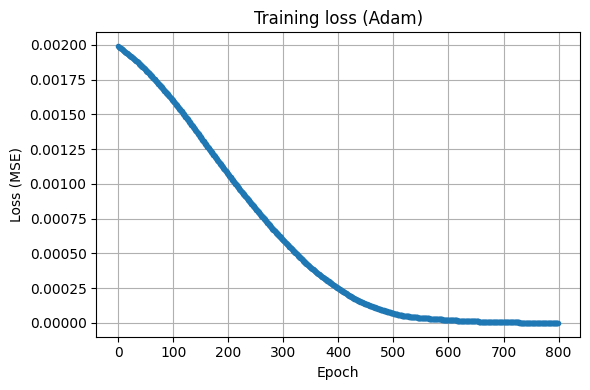

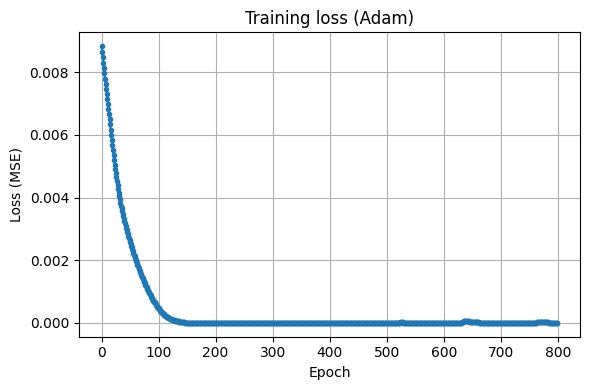

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(loss_lc_avg_arr, marker="o", markersize=3)
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training loss (Adam)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(loss_cont_avg_arr, marker="o", markersize=3)
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training loss (Adam)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
facet_coords[0]

array([[0.  , 0.75, 0.  ],
       [0.25, 1.  , 0.  ]])

In [25]:
LCE_CG = []
LCE_rec = []
indices = []

LCE_CG_int = []
LCE_rec_int = []
indices_int = []
for local_cell_idx, cell_verts in enumerate(tqdm(local_cell_vertices)):
    # cell_verts are global vertex indices
    coords = omega_geometry[cell_verts]  # shape (3,2)
    coords_t = torch.tensor(coords, dtype=torch.float32, device=device)
    sd = cell_to_subdomain(local_cell_idx)
    net_sd = nets[sd]
    centroid = np.mean(coords, axis=0).reshape(1,-1)
    centroid_t = torch.tensor(centroid, dtype=torch.float32, device=device).squeeze()

    loc_cells = np.array([[0, 1, 2]], dtype=np.int64)

    gdim = coords.shape[1]
    coord_el = basix.ufl.element("Lagrange", "triangle", 1, shape=(gdim,))

    local_mesh = dmesh.create_mesh(
        MPI.COMM_SELF,
        loc_cells,
        coord_el,   # <-- this is the required "e" argument
        coords
    )
    cell_dofs = V.dofmap.cell_dofs(local_cell_idx)
    # -------------------------------------------------
    # 2. Local vector CG2 space for r_θ
    # -------------------------------------------------
    # Vector-valued CG2 (shape=(gdim,))
    V_loc = fem.functionspace(local_mesh, ("CG", order+1, (gdim,)))
    # r_loc = fem.Function(V_loc)

    # -------------------------------------------------
    # 3. Interpolate NN into r_loc via dof coordinates
    # -------------------------------------------------
    x_loc = V_loc.tabulate_dof_coordinates()[:,0:2]  # (Ndofs, gdim)
    x_loc_torch = torch.tensor(x_loc, dtype=torch.float32)      # NN input

    # r_vals_torch = net(x_loc_torch)                             # (Ndofs, gdim)
    # r_vals = r_vals_torch.detach().cpu().numpy().reshape(-1)

    # assign to local FEM function
    # r_loc.x.array[:] = r_vals.astype(default_scalar_type)

    # -------------------------------------------------
    # 4. Compute ∫_{∂D_j} r_θ · n ds on local mesh
    # -------------------------------------------------
    n_K = ufl.FacetNormal(local_mesh)
    # int_r_form = fem.form(ufl.dot(r_loc, n_K) * ufl.ds)

    edge_indices = [(0, 1), (1, 2), (2, 0)]
    int_r_local = torch.zeros((), device=device)

    num_sub = 3 #sub integral section

    for (i0, i1) in edge_indices:
        x0 = coords_t[i0]
        x1 = coords_t[i1]
        t = x1 - x0
        L = torch.linalg.norm(t)
        if L <= 0:
            continue

        n_edge = (torch.stack([t[1], -t[0]]) / L)
        n_edge = torch.tensor(n_edge, dtype=torch.float32)
        centroid_t = torch.tensor(centroid, dtype=torch.float32, device=device).squeeze()
        midpoint = 0.5 * (x0 + x1)
        if torch.dot(n_edge, centroid_t - midpoint) > 0:
            n_edge = -n_edge
        int_r_local += integrate_edge_flux(net_sd, x0, x1, n_edge, L, xi, wi, num_sub=3)
    # int_r_local = fem.assemble_scalar(int_r_form)

    # -------------------------------------------------
    # 5. Combine with q_cg and f (precomputed per cell)
    # -------------------------------------------------
    P_loc = fem.functionspace(local_mesh, ("CG", order))
    p_K = fem.Function(P_loc)

    # DOFs on this cell in the global space
    global_dofs = V.dofmap.cell_dofs(local_cell_idx)

    # DOFs on the (only) cell in the local space
    local_dofs = P_loc.dofmap.cell_dofs(0)

    p_K.x.array[local_dofs] = p_sol.x.array[global_dofs]
    p_K.x.scatter_forward()

    k_m_loc = fem.Function(P_loc)
    k_m_loc.x.array[local_dofs] = k_m.x.array[global_dofs]

    q_CG = -k_m_loc * ufl.grad(p_K)
    int_qcg = fem.assemble_scalar(
                fem.form(ufl.dot(q_CG, n_K) * ufl.ds(domain=local_mesh))
            )   # ∫_{∂D_j} q_cg · n
    
    f_m_loc = fem.Function(P_loc)
    f_m_loc.x.array[local_dofs] = f.x.array[global_dofs]
    f_m_loc.x.scatter_forward()
    int_f   = fem.assemble_scalar(fem.form(f_m_loc * ufl.dx(domain=local_mesh)))       # ∫_{D_j} f

    residual_j = float(int_r_local) + int_qcg - int_f

    LCE_CG.append(int_qcg - int_f)
    LCE_rec.append(residual_j)
    indices.append(local_cell_idx)

    left_dofs_P = fem.locate_dofs_geometrical(
        P_loc, lambda x: np.isclose(x[0], xmin, atol=tol)
    )
    right_dofs_P = fem.locate_dofs_geometrical(
        P_loc, lambda x: np.isclose(x[0], xmax, atol=tol)
    )

    if (len(left_dofs_P) == 0) and (len(right_dofs_P) == 0):
        LCE_CG_int.append(int_qcg - int_f)
        LCE_rec_int.append(residual_j)
        indices_int.append(local_cell_idx)

  0%|          | 0/32 [00:00<?, ?it/s]

/tmp/ipykernel_155929/3755142680.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  n_edge = torch.tensor(n_edge, dtype=torch.float32)
100%|██████████| 32/32 [00:00<00:00, 91.87it/s]


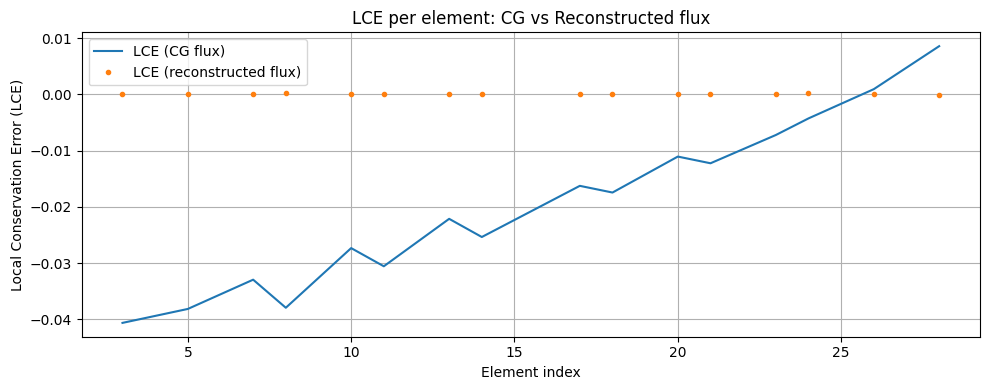

CG LCE stats: {'min': -0.040656155838956, 'max': 0.008584153903628133, 'L1_mean_abs': 0.020829529496065684, 'L2_rms': 0.024293492410061422}
Reconstructed LCE stats: {'min': -3.966961989329077e-05, 'max': 0.00021988553646053177, 'L1_mean_abs': 9.855929679275055e-05, 'L2_rms': 0.00011087053058425924}


In [26]:

indices_plot = np.array(indices_int, dtype=int)
LCE_CG_plot = np.array(LCE_CG_int, dtype=float)
LCE_rec_plot = np.array(LCE_rec_int, dtype=float)

# plot
plt.figure(figsize=(10,4))
plt.plot(indices_plot, LCE_CG_plot, label="LCE (CG flux)")
plt.plot(indices_plot, LCE_rec_plot, ".", label="LCE (reconstructed flux)")
plt.xlabel("Element index")
plt.ylabel("Local Conservation Error (LCE)")
plt.title("LCE per element: CG vs Reconstructed flux")
plt.legend()
plt.grid(True)
plt.tight_layout()
# out_path = "/mnt/data/lce_plot.png"
# plt.savefig(out_path)
plt.show()

# print stats & produce dataframe
def stats(arr):
    return {"min": float(arr.min()), "max": float(arr.max()), "L1_mean_abs": float(np.mean(np.abs(arr))), "L2_rms": float(np.sqrt(np.mean(arr**2)))}
print("CG LCE stats:", stats(LCE_CG_plot))
print("Reconstructed LCE stats:", stats(LCE_rec_plot))

In [50]:
loss_sd_plot

array([5.69976510e-05, 1.52704059e-04, 7.21774569e-08, 1.03544822e-04,
       5.92164679e-06, 8.41540823e-05, 3.13956406e-07, 1.20892662e-04,
       1.63676115e-04, 1.63292441e-06, 4.05107639e-05, 2.89268413e-04,
       1.86495663e-06, 1.35552900e-05, 1.40688586e-04, 1.01898867e-03,
       1.36933443e-06, 1.25997994e-05, 1.05791216e-04, 2.80192500e-04,
       6.10160498e-07, 5.60323824e-05, 7.25164718e-04, 1.13384986e-05,
       7.05880529e-06, 7.66833036e-05, 1.57832278e-06, 1.29363179e-04,
       2.40647842e-06, 2.05258839e-05, 1.18033668e-05, 8.41395697e-04])

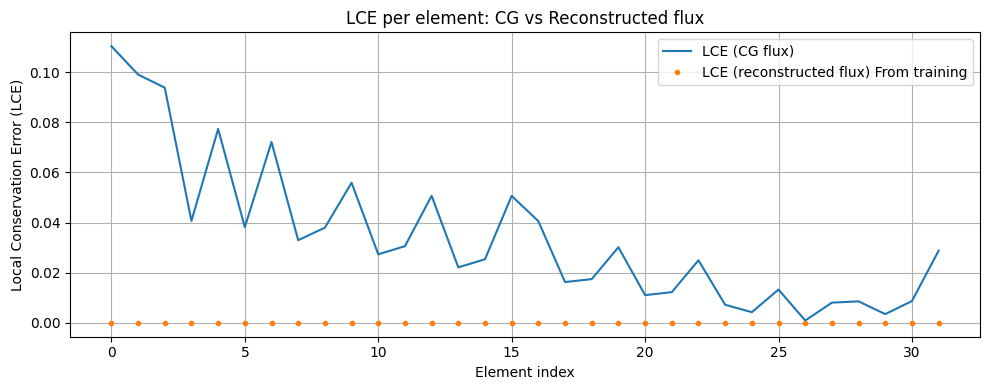

CG LCE stats: {'min': -0.11032507916452518, 'max': 0.028783362314176376, 'L1_mean_abs': 0.034406573321158616, 'L2_rms': 0.04471424247049781}
Reconstructed LCE stats: {'min': -0.0037409233333181025, 'max': 0.00026310932819937835, 'L1_mean_abs': 0.00020511698589971357, 'L2_rms': 0.0006698777258046512}


In [32]:
import matplotlib.pyplot as plt
indices_plot = np.array(indices, dtype=int)
LCE_CG_plot = np.array(LCE_CG, dtype=float)
LCE_rec_plot = np.array(LCE_rec, dtype=float)
loss_sd_plot = np.array([float(cc.detach()) for cc in loss_sd])

# plot
plt.figure(figsize=(10,4))
plt.plot(indices_plot, np.abs(LCE_CG_plot), label="LCE (CG flux)")
# plt.plot(indices_plot, np.abs(LCE_rec_plot), ".", label="LCE (reconstructed flux)")
plt.plot(indices_plot, np.abs(loss_sd_plot), ".", label="LCE (reconstructed flux) From training")
plt.xlabel("Element index")
plt.ylabel("Local Conservation Error (LCE)")
plt.title("LCE per element: CG vs Reconstructed flux")
plt.legend()
plt.grid(True)
plt.tight_layout()
# out_path = "/mnt/data/lce_plot.png"
# plt.savefig(out_path)
plt.show()

# print stats & produce dataframe
def stats(arr):
    return {"min": float(arr.min()), "max": float(arr.max()), "L1_mean_abs": float(np.mean(np.abs(arr))), "L2_rms": float(np.sqrt(np.mean(arr**2)))}
print("CG LCE stats:", stats(LCE_CG_plot))
print("Reconstructed LCE stats:", stats(LCE_rec_plot))

In [109]:
jump_CG = []
jump_rec = []
jump_indices = []

tdim = omega.topology.dim
gdim = omega.geometry.dim

# vertex -> cell connectivity (global)
cells_vtx = omega.topology.connectivity(0, tdim)
if cells_vtx is None:
    omega.topology.create_connectivity(0, tdim)
    cells_vtx = omega.topology.connectivity(0, tdim)

# cell -> vertex connectivity (global), should already exist
ctv = omega.topology.connectivity(tdim, 0)
if ctv is None:
    omega.topology.create_connectivity(tdim, 0)
    ctv = omega.topology.connectivity(tdim, 0)

# Coordinate element for local 1-cell meshes
coord_el = basix.ufl.element("Lagrange", "triangle", 1, shape=(gdim,))
# Local cell topology for each local mesh (single triangle)
loc_cells = np.array([[0, 1, 2]], dtype=np.int64)

for facet_idx, facet_verts in enumerate(tqdm(facet_vertices)):
    # facet_verts: global vertex indices of this facet (length 2 in 2D)
    v0, v1 = facet_verts

    # i0 = facet_coords[facet_idx][0, 0:2]
    # i1 = facet_coords[facet_idx][1, 0:2]
    # i0, i1 are the physical coordinates of the facet endpoints (not used below,
    # but you may keep them if needed for debugging / plotting)

    # -------------------------------------------------
    # 1. Determine the (up to) 2 elements sharing this facet
    # -------------------------------------------------
    cells0 = cells_vtx.links(v0)
    cells1 = cells_vtx.links(v1)
    common_cells = np.intersect1d(cells0, cells1)

    # If no cells share both vertices, skip (should not happen in a valid mesh)
    if common_cells.size == 0:
        continue

    facet_fluxes = []
    facet_fluxes_rec = []

    # -------------------------------------------------
    # 2. For each cell sharing the facet: create a local mesh, tag facet, compute flux
    # -------------------------------------------------
    for cell in common_cells:
        # Global vertices of this cell
        cell_verts = ctv.links(cell)            # e.g. [v_a, v_b, v_c]
        coords_K = omega_geometry[cell_verts]   # shape (3, gdim)

        # --- 2a. Local 1-cell mesh for this cell
        local_mesh = dmesh.create_mesh(
            MPI.COMM_SELF,
            loc_cells,
            coord_el,
            coords_K
        )
        sd = cell_to_subdomain(cell)

        # --- 2b. Local CG space (same order as V / p_sol)
        P_loc = fem.functionspace(local_mesh, ("CG", order))
        p_K = fem.Function(P_loc)
        k_m_loc = fem.Function(P_loc)

        # Map global DOFs from this cell to local DOFs of the local mesh
        global_dofs = V.dofmap.cell_dofs(cell)
        local_dofs = P_loc.dofmap.cell_dofs(0)

        p_K.x.array[local_dofs] = p_sol.x.array[global_dofs]
        p_K.x.scatter_forward()

        k_m_loc.x.array[local_dofs] = k_m.x.array[global_dofs]
        k_m_loc.x.scatter_forward()

        # --- 2c. Flux on this cell: q_CG = -k_m * grad p_K
        q_CG = -k_m_loc * ufl.grad(p_K)

        # --- 2d. Find which local facet corresponds to the global edge (v0, v1)
        # cell_verts gives the global verts in local order [0,1,2]
        lv0 = np.where(cell_verts == v0)[0][0]
        lv1 = np.where(cell_verts == v1)[0][0]

        local_edges = [(0, 1), (1, 2), (0, 2)]
        local_facet_index = None
        for ei, (a, b) in enumerate(local_edges):
            if {a, b} == {lv0, lv1}:
                local_facet_index = ei
                break
        assert local_facet_index is not None, "Could not match facet to local edge"

        # --- 2e. Tag this local facet on the local mesh
        tdim_loc = local_mesh.topology.dim
        fdim_loc = tdim_loc - 1

        local_mesh.topology.create_entities(fdim_loc)
        if local_mesh.topology.connectivity(fdim_loc, 0) is None:
            local_mesh.topology.create_connectivity(fdim_loc, 0)

        facets = np.array([local_facet_index], dtype=np.int32)
        values = np.array([1], dtype=np.int32)  # label = 1 for this facet

        mt = dmesh.meshtags(local_mesh, fdim_loc, facets, values)
        ds_loc = ufl.Measure("ds", domain=local_mesh, subdomain_data=mt)
        n_K = ufl.FacetNormal(local_mesh)

        # --- 2f. Flux integral over THIS cell's side of the facet
        flux_i = fem.assemble_scalar(
            fem.form(ufl.dot(q_CG, n_K) * ds_loc(1))
        )
        facet_fluxes.append(flux_i)

        # ---- geometric data (on the right device) ----
        cell_verts = local_cell_vertices[cell]
        coords = omega_geometry[cell_verts]
        centroid = np.mean(coords, axis=0).reshape(1, -1)
        centroid_t = torch.tensor(centroid, dtype=torch.float32, device=device).squeeze()
        x0 = torch.tensor(omega_geometry[v0], dtype=torch.float32, device=device)
        x1 = torch.tensor(omega_geometry[v1], dtype=torch.float32, device=device)

        t = x1 - x0
        L = torch.linalg.norm(t)
        if L <= 0:
            continue

        n_edge = torch.stack([t[1], -t[0]]) / L
        midpoint = 0.5 * (x0 + x1)
        if torch.dot(n_edge, centroid_t - midpoint) > 0:
            n_edge = -n_edge

        # subdomain pair sharing this edge
        # if vertex_subdomains[i0][0] == sd:
        #     sd_adj = vertex_subdomains[i0][1]
        # elif vertex_subdomains[i0][1] == sd:
        #     sd_adj = vertex_subdomains[i0][0]
        net_sd = nets[sd]

        int_net_edge = integrate_edge_flux(net_sd, x0, x1, n_edge, L, xi, wi, num_sub=3)
        facet_fluxes_rec.append(flux_i + float(int_net_edge))

    # -------------------------------------------------
    # 3. Jump on this facet = sum of fluxes from both sides
    #    (since normals are outward from each cell)
    # -------------------------------------------------
    if len(facet_fluxes) == 2:
        jump_val_CG = facet_fluxes[0] + facet_fluxes[1]
        jump_val_rec = facet_fluxes_rec[0] + facet_fluxes_rec[1]
    else:
        # boundary facet (only one adjacent cell)
        # you may want to set this to 0 instead, depending on definition
        jump_val_CG = facet_fluxes[0]*0

    jump_CG.append(jump_val_CG)
    jump_rec.append(jump_val_rec)          # placeholder, you'll add reconstructed later
    jump_indices.append(facet_idx)


100%|██████████| 56/56 [00:00<00:00, 152.50it/s]


In [28]:
jump_CG = []
jump_rec = []
jump_indices = []   # cell indices

tdim = omega.topology.dim
gdim = omega.geometry.dim

# --- vertex -> cell connectivity (global) ---
cells_vtx = omega.topology.connectivity(0, tdim)
if cells_vtx is None:
    omega.topology.create_connectivity(0, tdim)
    cells_vtx = omega.topology.connectivity(0, tdim)

# --- cell -> vertex connectivity (global) ---
ctv = omega.topology.connectivity(tdim, 0)
if ctv is None:
    omega.topology.create_connectivity(tdim, 0)
    ctv = omega.topology.connectivity(tdim, 0)

num_cells = omega.topology.index_map(tdim).size_local

# Coordinate element for local 1-cell meshes
coord_el = basix.ufl.element("Lagrange", "triangle", 1, shape=(gdim,))
loc_cells = np.array([[0, 1, 2]], dtype=np.int64)

local_edges = [(0, 1), (1, 2), (0, 2)]

for cell in range(num_cells):
    cell_jump_CG = 0.0
    cell_jump_rec = 0.0

    cell_verts = ctv.links(cell)
    coords_K = omega_geometry[cell_verts]

    sd = cell_to_subdomain(cell)

    # --- geometric data for this cell ---
    centroid = np.mean(coords_K, axis=0).reshape(1, -1)
    centroid_t = torch.tensor(centroid, dtype=torch.float32, device=device).squeeze()

    for local_edge_idx, (la, lb) in enumerate(local_edges):
        v0 = cell_verts[la]
        v1 = cell_verts[lb]

        # ---- neighboring cell sharing this edge ----
        cells0 = cells_vtx.links(v0)
        cells1 = cells_vtx.links(v1)
        common_cells = np.intersect1d(cells0, cells1)

        if common_cells.size == 0:
            continue

        neighbor_cells = [int(c) for c in common_cells if int(c) != cell]

        # boundary edge → no contribution
        if len(neighbor_cells) == 0:
            continue

        cell_adj = neighbor_cells[0]

        facet_fluxes = []
        facet_fluxes_rec = []

        # ---------- two-sided loop (cell + neighbor) ----------
        for cell_side in (cell, cell_adj):
            cell_verts_side = ctv.links(cell_side)
            coords_side = omega_geometry[cell_verts_side]

            local_mesh = dmesh.create_mesh(
                MPI.COMM_SELF,
                loc_cells,
                coord_el,
                coords_side
            )

            tdim_loc = local_mesh.topology.dim
            fdim_loc = tdim_loc - 1
            local_mesh.topology.create_entities(fdim_loc)
            if local_mesh.topology.connectivity(fdim_loc, 0) is None:
                local_mesh.topology.create_connectivity(fdim_loc, 0)

            sd_side = cell_to_subdomain(cell_side)
            net_sd = nets[sd_side]

            P_loc = fem.functionspace(local_mesh, ("CG", order))
            p_K = fem.Function(P_loc)
            k_m_loc = fem.Function(P_loc)

            global_dofs = V.dofmap.cell_dofs(cell_side)
            local_dofs = P_loc.dofmap.cell_dofs(0)

            p_K.x.array[local_dofs] = p_sol.x.array[global_dofs]
            p_K.x.scatter_forward()

            k_m_loc.x.array[local_dofs] = k_m.x.array[global_dofs]
            k_m_loc.x.scatter_forward()

            q_CG = -k_m_loc * ufl.grad(p_K)
            n_K = ufl.FacetNormal(local_mesh)

            # vertex–facet connectivity
            local_mesh.topology.create_connectivity(0, fdim_loc)
            local_mesh.topology.create_connectivity(fdim_loc, 0)
            v_to_f = local_mesh.topology.connectivity(0, fdim_loc)
            f_to_v = local_mesh.topology.connectivity(fdim_loc, 0)

            lv0 = int(np.where(cell_verts_side == v0)[0][0])
            lv1 = int(np.where(cell_verts_side == v1)[0][0])

            edge_id = None
            for ff in v_to_f.links(lv0):
                if lv1 in f_to_v.links(ff):
                    edge_id = ff
                    break
            assert edge_id is not None

            mt = dmesh.meshtags(
                local_mesh,
                fdim_loc,
                np.array([edge_id], dtype=np.int32),
                np.array([1], dtype=np.int32)
            )
            ds = ufl.Measure("ds", domain=local_mesh, subdomain_data=mt)

            flux_i = fem.assemble_scalar(
                fem.form(ufl.dot(q_CG, n_K) * ds(1))
            )
            facet_fluxes.append(flux_i)

            # ----- NN reconstructed flux -----
            centroid_side = np.mean(coords_side, axis=0).reshape(1, -1)
            centroid_t_side = torch.tensor(
                centroid_side, dtype=torch.float32, device=device
            ).squeeze()

            x0 = torch.tensor(omega_geometry[v0], dtype=torch.float32, device=device)
            x1 = torch.tensor(omega_geometry[v1], dtype=torch.float32, device=device)

            t = x1 - x0
            L = torch.linalg.norm(t)
            if L <= 0:
                continue

            n_edge = torch.stack([t[1], -t[0]]) / L
            midpoint = 0.5 * (x0 + x1)
            if torch.dot(n_edge, centroid_t_side - midpoint) > 0:
                n_edge = -n_edge

            int_net_edge = integrate_edge_flux(
                net_sd, x0, x1, n_edge, L, xi, wi, num_sub=3
            )
            facet_fluxes_rec.append(flux_i + float(int_net_edge))

        # ---------- sum jump on this edge ----------
        if len(facet_fluxes) == 2:
            cell_jump_CG += facet_fluxes[0] + facet_fluxes[1]
            cell_jump_rec += facet_fluxes_rec[0] + facet_fluxes_rec[1]

    # ---------- append ONCE per cell ----------
    jump_CG.append(cell_jump_CG)
    jump_rec.append(cell_jump_rec)
    jump_indices.append(cell)

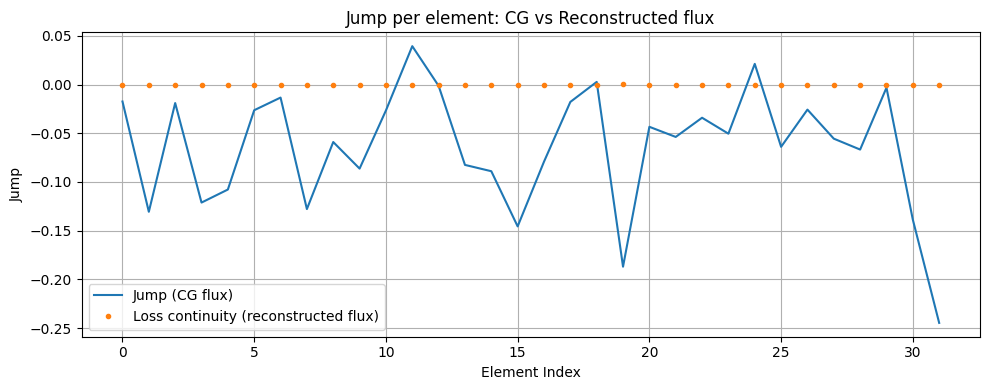

In [31]:

jump_indices_plot = np.array(jump_indices, dtype=int)
jump_CG_plot = np.array(jump_CG, dtype=float)
jump_rec_plot = np.array(jump_rec, dtype=float)
loss_continuity_plot = np.array([cc.detach() for cc in loss_continuity_sd])

# plot
plt.figure(figsize=(10,4))
plt.plot(jump_indices_plot, jump_CG_plot, label="Jump (CG flux)")
# plt.plot(jump_indices_plot, jump_rec_plot, ".", label="Jump (reconstructed flux)")
plt.plot(jump_indices_plot, loss_continuity_plot, ".", label="Loss continuity (reconstructed flux)")
plt.xlabel("Element Index")
plt.ylabel("Jump")
plt.title("Jump per element: CG vs Reconstructed flux")
plt.legend()
plt.grid(True)
plt.tight_layout()
# out_path = "/mnt/data/lce_plot.png"
# plt.savefig(out_path)
plt.show()

# print stats & produce dataframe
# def stats(arr):
#     return {"min": float(arr.min()), "max": float(arr.max()), "L1_mean_abs": float(np.mean(np.abs(arr))), "L2_rms": float(np.sqrt(np.mean(arr**2)))}
# print("CG LCE stats:", stats(LCE_CG_plot))
# print("Reconstructed LCE stats:", stats(LCE_rec_plot))

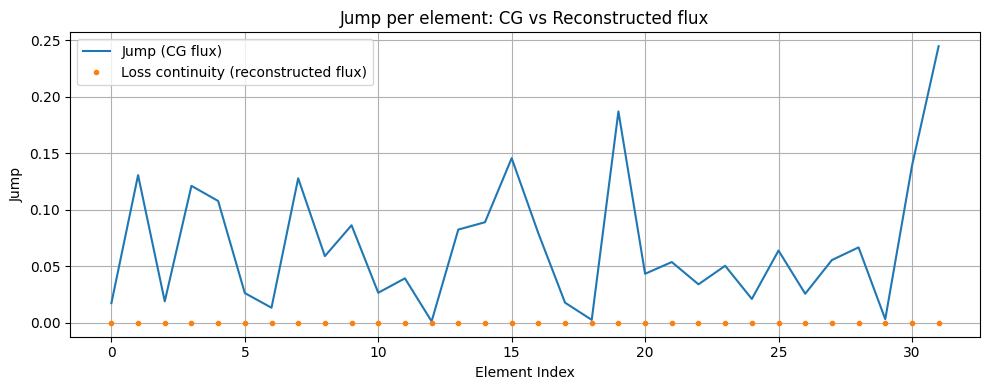

In [30]:
# plot
plt.figure(figsize=(10,4))
plt.plot(jump_indices_plot, abs(jump_CG_plot), label="Jump (CG flux)")
# plt.plot(jump_indices_plot, jump_rec_plot, ".", label="Jump (reconstructed flux)")
plt.plot(jump_indices_plot, abs(loss_continuity_plot), ".", label="Loss continuity (reconstructed flux)")
plt.xlabel("Element Index")
plt.ylabel("Jump")
plt.title("Jump per element: CG vs Reconstructed flux")
plt.legend()
plt.grid(True)
plt.tight_layout()
# out_path = "/mnt/data/lce_plot.png"
# plt.savefig(out_path)
plt.show()